# Seam Phase 1 data creation with Devito - Direct wave only

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import segyio
import numpy as np
import random
import matplotlib.pyplot as plt
import pylops
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import RegularGridInterpolator
from examples.seismic import Model, RickerSource

from waveeqmod import Acoustic2DDevito
from utils import fixed_to_fixed_streamer, fixed_to_continous_streamer

## Velocity model

In [2]:
# Dimensions
nz, ny, nx = 1501, 2001, 1751
dz, dy, dx = 10, 20, 20

# Resample on 12.5 x 12.5 grid
x = np.arange(nx) * dx
z = np.arange(nz) * dz
xint = np.arange(x[0], x[-1], 12.5)
zint = np.arange(z[0], z[-1], 12.5)
nxint, nzint = len(xint), len(zint)

# Velocity
vp2dwater = 1490 * np.ones((nxint, nzint), dtype=np.float32)

In [3]:
vp2dwater.shape

(2800, 1200)

## Acquisition geometry

In [4]:
#model parameter
shape = (nxint, nzint)
spacing = (12.5, 12.5)
origin = (0, 0)

#geometry arrange
nsrc = 501
nrec = nxint
osrc = spacing[0]*800

# other modelling params
nbl = 150 # Number of boundary layers around the domain
space_order = 6 # Space order of the simulation
f0 = 10 # Source peak frequency (1/ms)
fs = True
fslabel = '_fs' if fs else ''

t0 = 0.
tn = 30000 # Total simulation time
tn_blen = 1000000 # Total simulation time of blended data
dt_obs = 4 # Time sampling of observed data

In [5]:
awe = Acoustic2DDevito()

awe.create_model(shape, origin, spacing, vp2dwater, space_order, nbl=nbl, fs=fs, dt=1.385)
awe.create_geometry(src_x=np.arange(0, nsrc) * spacing[0] + osrc,
                    src_z=20,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=20,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

Operator `initdamp` ran in 0.02 s
INFO: Operator `initdamp` ran in 0.02 s
Operator `pad_vp` ran in 0.01 s
INFO: Operator `pad_vp` ran in 0.01 s


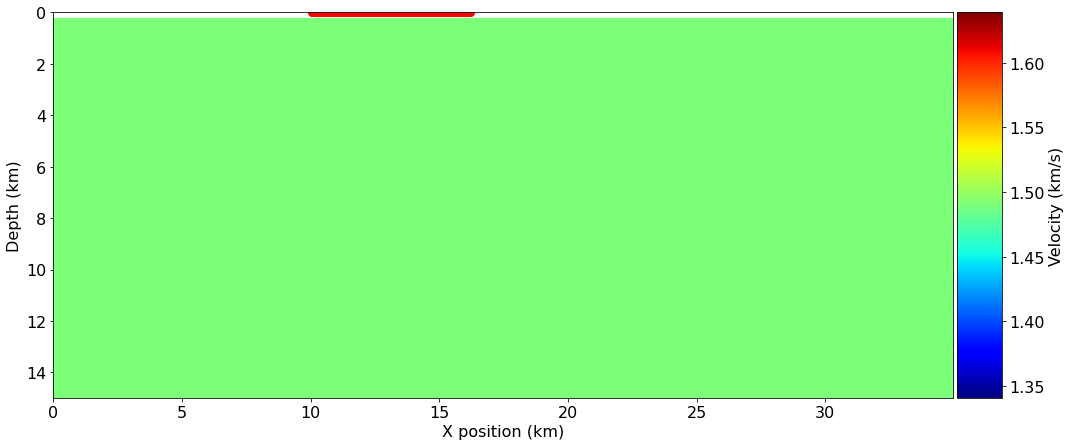

In [6]:
awe.plot_velocity(figsize=(17, 9))

In [7]:
awe.geometry.dt

1.385

## Solve one shot

In [8]:
isrc = 0
d, _, _ = awe.solve_one_shot(isrc)
d = d.resample(dt_obs)
taxistot = d.time_values

Operator `Forward` ran in 52.61 s
INFO: Operator `Forward` ran in 52.61 s


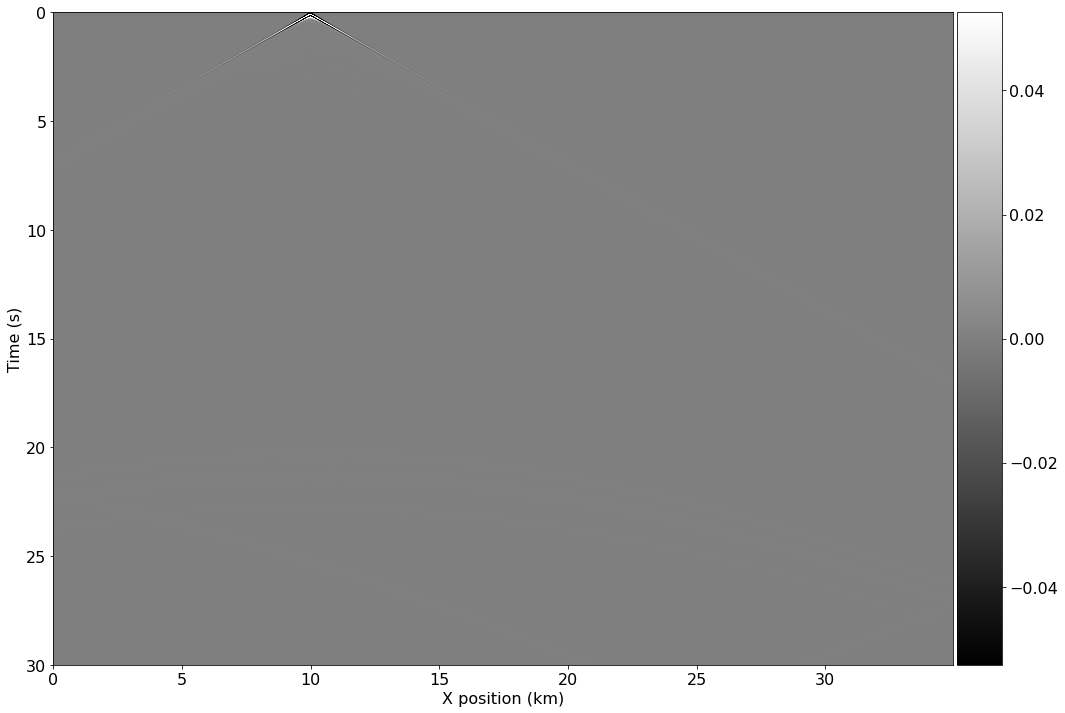

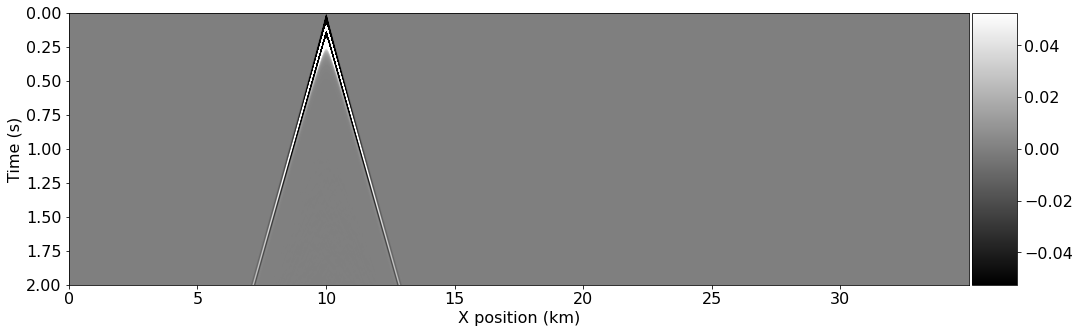

In [9]:
ax = awe.plot_shotrecord(d.data, clip=1e-3)

ax = awe.plot_shotrecord(d.data, clip=1e-3, figsize=(17, 5))
ax.set_ylim(2, 0);

In [10]:
nrec_streamer=500
ioffrec_streamer = 11 # source-rec offset (in indices)

d = d.data[:]
dstreamer = fixed_to_fixed_streamer(awe.geometry.src_positions[:1, 0], 
                                    awe.geometry.rec_positions[:, 0], 
                                    d.T[np.newaxis, :, :], 
                                    nrec_streamer=nrec_streamer, ioffrec_streamer=ioffrec_streamer)

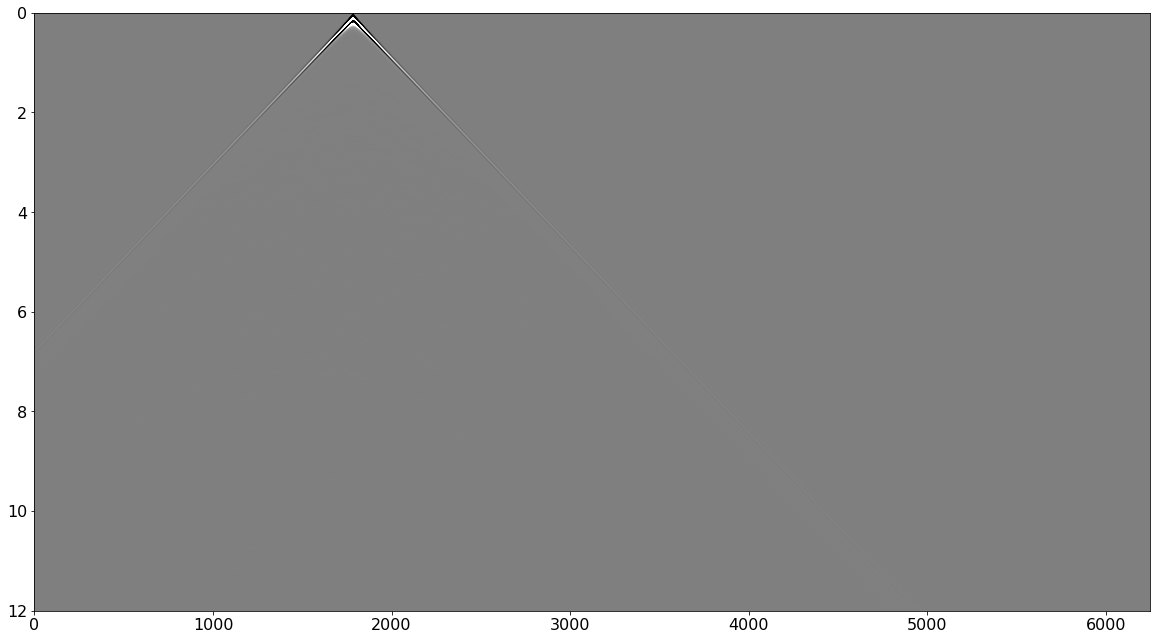

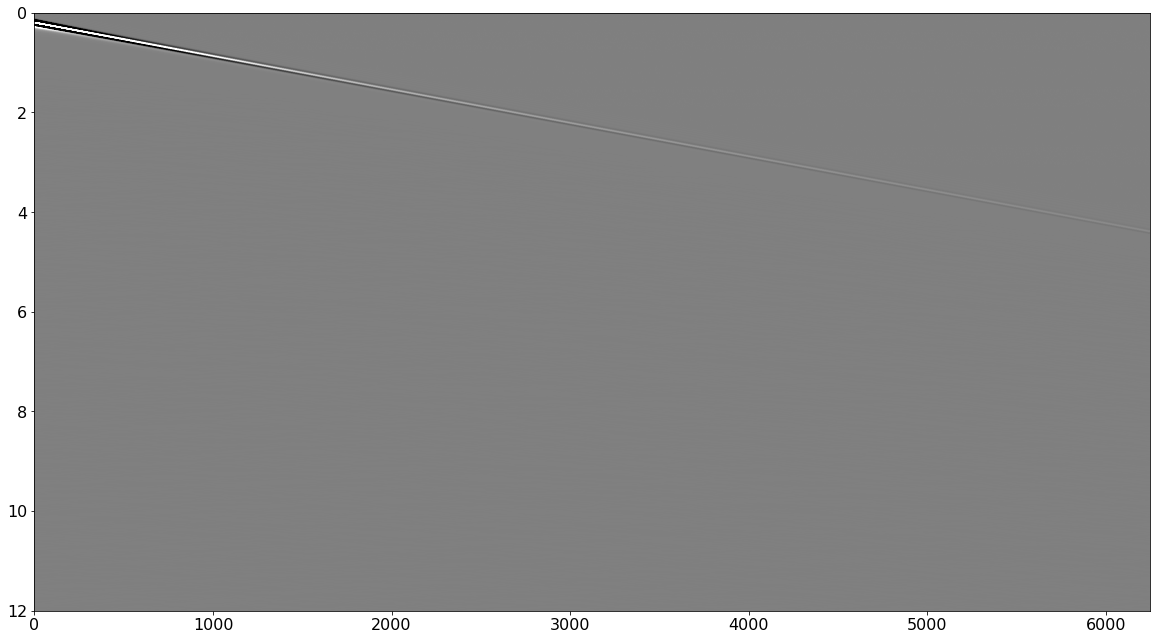

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 11))
ax.imshow(d, extent=(0, nrec_streamer*12.5, taxistot[-1] * 1e-3, taxistot[0] * 1e-3), 
          vmin=-1e-1, vmax=1e-1, cmap='gray')
ax.axis('tight')
ax.set_ylim(12, 0);

fig, ax = plt.subplots(1, 1, figsize=(20, 11))
ax.imshow(dstreamer[0].T, extent=(0, nrec_streamer*12.5, taxistot[-1] * 1e-3, taxistot[0] * 1e-3), 
          vmin=-1e-1, vmax=1e-1, cmap='gray')
ax.axis('tight')
ax.set_ylim(12, 0);

In [12]:
np.savez(f'shots{fslabel}_open/Streamerdir', d=dstreamer[0].astype(np.float32), t=taxistot, 
         src=awe.geometry.src_positions, rec=awe.geometry.rec_positions)